In [1]:
import os
import torch
import librosa
import torchaudio
import numpy as np
import pandas as pd
import soundfile as sf
import plotly.express as px
import matplotlib.pyplot as plt

from IPython.display import Audio
from torch.utils.data import Dataset

In [43]:
root_dir = '/Users/rudyh/Documents/Python/datasets/Bio-Akustik-Gajah/'
metadata_dir = os.path.join(root_dir, 'segmented_audio_data_v3')
audio_file = os.path.join(root_dir, 'segmented_audio_data_v2')

metadata = pd.read_csv(os.path.join(root_dir, metadata_dir, 'segmented_audio_data_v3.csv'))
metadata.shape

(1554, 8)

In [36]:
metadata.head()

,filename,sound_type,sample_rate,num_frames,num_channels,bits_per_sample,encoding,class_id
0,trumpet_0.wav,trumpet,22050,10441,1,16,PCM_S,0
1,trumpet_1.wav,trumpet,22050,16705,1,16,PCM_S,0
2,trumpet_2.wav,trumpet,22050,12529,1,16,PCM_S,0
3,trumpet_3.wav,trumpet,22050,11074,1,16,PCM_S,0
4,trumpet_4.wav,trumpet,22050,15011,1,16,PCM_S,0


### Attach Audio Directory to `filename` column

In [4]:
metadata['filename'] = metadata['filename'].apply(lambda x: os.path.join(audio_file, x))
metadata['filename'][100]

'/Users/rudyh/Documents/Python/datasets/Bio-Akustik-Gajah/segmented_audio_data_v2\\rumble_65.wav'

### Inspect Number of Frames

In [5]:
metadata['num_frames'].describe()

count      1554.000000
mean      74579.667954
std       53327.404956
min           0.000000
25%       27799.250000
50%       63973.000000
75%      109944.000000
max      300033.000000
Name: num_frames, dtype: float64

In [6]:
metadata[(metadata['num_frames'] > 20000) & (metadata['num_frames'] < 30000)]

,filename,sound_type,sample_rate,num_frames,num_channels,bits_per_sample,encoding,class_id
11,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,roar,22050,28538,1,16,PCM_S,2
13,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,roar,22050,27146,1,16,PCM_S,2
17,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,roar,22050,20674,1,16,PCM_S,2
18,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,roar,22050,21928,1,16,PCM_S,2
28,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,trumpet,22050,23874,1,16,PCM_S,0
...,...,...,...,...,...,...,...,...
1541,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,trumpet,22050,28787,1,16,PCM_S,0
1542,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,trumpet,22050,21591,1,16,PCM_S,0
1544,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,trumpet,22050,26989,1,16,PCM_S,0
1547,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,trumpet,22050,27596,1,16,PCM_S,0


In [37]:
# Get the length of audio file in seconds
def get_audio_length(file_path):
	audio, sample_rate = librosa.load(file_path)
	return librosa.get_duration(audio, sample_rate)

# Get the length of audio file in seconds
def get_audio_length_torchaudio(file_path):
	audio, sample_rate = torchaudio.load(file_path)
	return audio.shape[1] / sample_rate

# Get the length of audio file in seconds
def get_audio_length_soundfile(file_path):
	audio, sample_rate = sf.read(file_path)
	return len(audio) / sample_rate

There are some files that have 0 frames, so we need to remove them. But, to make sure that we don't remove the wrong files, we need to inspect the `num_frames` column and get the length of the files in seconds.

```python

In [44]:
# Remove audio with num_frames == 0
metadata = metadata[metadata['num_frames'] != 0].copy()
metadata['num_frames'].describe()

count      1534.000000
mean      75552.023468
std       52984.922746
min        6436.000000
25%       29234.250000
50%       65449.000000
75%      110589.500000
max      300033.000000
Name: num_frames, dtype: float64

In [45]:
# Get the length of audio file in seconds
metadata['audio_length_seconds'] = metadata['filename'].apply(lambda x: get_audio_length_torchaudio(os.path.join(audio_file, x)))
metadata['audio_length_seconds'].describe()

count    1534.000000
mean        3.426396
std         2.402944
min         0.291882
25%         1.325816
50%         2.968209
75%         5.015397
max        13.606939
Name: audio_length_seconds, dtype: float64

In [10]:
metadata[metadata['audio_length_seconds'] > 11]

,filename,sound_type,sample_rate,num_frames,num_channels,bits_per_sample,encoding,class_id,audio_length_seconds
170,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,growl,22050,256176,1,16,PCM_S,4,11.617959
181,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,growl,22050,300033,1,16,PCM_S,4,13.606939
189,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,rumble,22050,249911,1,16,PCM_S,1,11.333832
1358,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,rumble,22050,246384,1,16,PCM_S,1,11.173878


In [11]:
# Plot the distribution of audio length using plotly
fig = px.histogram(
	metadata, 
	x='audio_length_seconds', 
	nbins=100, 
	title='Distribution of Audio Length (seconds)', 
	labels={'audio_length_seconds': 'Audio Length (seconds)'},
)
fig.show()

In [22]:
metadata[(metadata['audio_length_seconds'] > 5) & (metadata['audio_length_seconds'] <= 5.5)]

,filename,sound_type,sample_rate,num_frames,num_channels,bits_per_sample,encoding,class_id,audio_length_seconds
19,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,rumble,22050,119455,1,16,PCM_S,1,5.417460
20,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,rumble,22050,114166,1,16,PCM_S,1,5.177596
60,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,rumble,22050,119013,1,16,PCM_S,1,5.397415
76,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,rumble,22050,118401,1,16,PCM_S,1,5.369660
77,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,rumble,22050,111900,1,16,PCM_S,1,5.074830
...,...,...,...,...,...,...,...,...,...
1386,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,rumble,22050,110339,1,16,PCM_S,1,5.004036
1389,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,rumble,22050,112275,1,16,PCM_S,1,5.091837
1396,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,rumble,22050,115159,1,16,PCM_S,1,5.222630
1440,/Users/rudyh/Documents/Python/datasets/Bio-Aku...,rumble,22050,119123,1,16,PCM_S,1,5.402404


In [24]:
# Inspect the audio file
waveform, sample_rate = torchaudio.load(metadata['filename'][19])
Audio(waveform.numpy(), rate=sample_rate)

### Analyze Audio Length according to its `sound_type`

In [33]:
# Group by sound_type by its audio length that longer than 5 seconds
metadata[(metadata['audio_length_seconds'] > 5)].groupby('sound_type').count()

,filename,sample_rate,num_frames,num_channels,bits_per_sample,encoding,class_id,audio_length_seconds
sound_type,,,,,,,,
growl,83,83,83,83,83,83,83,83
roar,1,1,1,1,1,1,1,1
roar_rumble,8,8,8,8,8,8,8,8
rumble,295,295,295,295,295,295,295,295


After inspecting the audio file, it can be concluded that there are a lot of noise in them. We need a mechanism to analyse the noise and reduce it.

```python

### Noise Analyzer


Ref:
https://librosa.org/doc/latest/auto_examples/plot_vocal_separation.html#vocal-separation

In [14]:
waveform, sample_rate = librosa.load(metadata['filename'][433])

# Compute the spectogram magnitude and phase
s_full, phase = librosa.magphase(librosa.stft(waveform))

slice(0, 430, None)


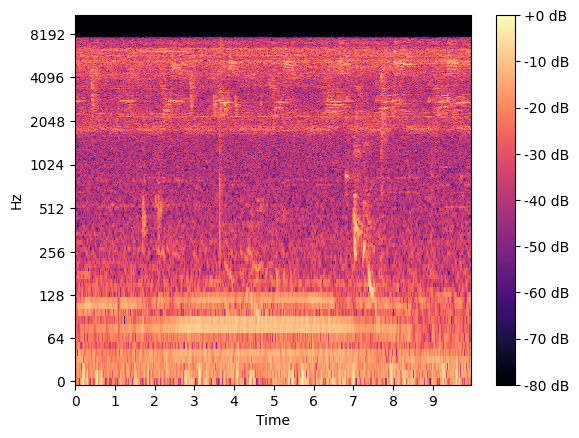

In [15]:
idx = slice(*librosa.time_to_frames([0, 10], sr=sample_rate))
print(idx)
fig, ax = plt.subplots()
img = librosa.display.specshow(
	librosa.amplitude_to_db(s_full[:, idx], ref=np.max),
	y_axis='log', x_axis='time', sr=sample_rate
)
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [16]:
s_filter = librosa.decompose.nn_filter(
	s_full,
	aggregate=np.median,
	metric='cosine',
	width=int(librosa.time_to_frames(2, sr=sample_rate))
)
s_filter = np.minimum(s_full, s_filter)

In [17]:
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(
	s_filter,
	margin_i * (s_full - s_filter),
	power=power
)

mask_v = librosa.util.softmask(
	s_full - s_filter,
	margin_v * s_filter,
	power=power
)

s_foreground = mask_v * s_full
s_background = mask_i * s_full

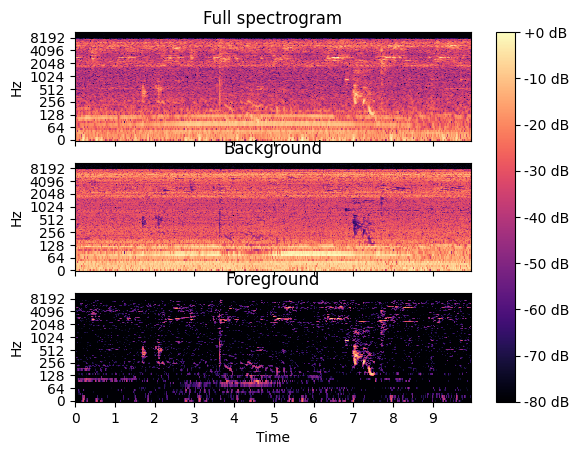

In [18]:
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
img = librosa.display.specshow(
	librosa.amplitude_to_db(s_full[:, idx], ref=np.max),
	y_axis='log', 
	x_axis='time', 
	sr=sample_rate, 
	ax=ax[0]
)
ax[0].set(title='Full spectrogram')
ax[0].label_outer()

librosa.display.specshow(
	librosa.amplitude_to_db(s_background[:, idx], ref=np.max),
	y_axis='log',
	x_axis='time',
	sr=sample_rate,
	ax=ax[1]
)
ax[1].set(title='Background')
ax[1].label_outer()

librosa.display.specshow(
	librosa.amplitude_to_db(s_foreground[:, idx], ref=np.max),
	y_axis='log',
	x_axis='time',
	sr=sample_rate,
	ax=ax[2]
)
ax[2].set(title='Foreground')
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [19]:
y_foreground = librosa.istft(s_foreground * phase)
Audio(data=y_foreground, rate=sample_rate)

Noise analysing is really difficult, therefore we can pending this for now.

```python

### Minority Class

In [25]:
metadata['sound_type'].value_counts()

rumble         743
trumpet        401
growl          214
roar           107
roar_rumble     54
bark_rumble      8
bark             7
Name: sound_type, dtype: int64

In [40]:
metadata.head()

,filename,sound_type,sample_rate,num_frames,num_channels,bits_per_sample,encoding,class_id,audio_length_seconds
0,trumpet_0.wav,trumpet,22050,10441,1,16,PCM_S,0,0.473515
1,trumpet_1.wav,trumpet,22050,16705,1,16,PCM_S,0,0.757596
2,trumpet_2.wav,trumpet,22050,12529,1,16,PCM_S,0,0.568209
3,trumpet_3.wav,trumpet,22050,11074,1,16,PCM_S,0,0.502222
4,trumpet_4.wav,trumpet,22050,15011,1,16,PCM_S,0,0.680771


### Save Dataframe to CSV

In [46]:
metadata.reset_index(inplace=True)
metadata = metadata.drop(columns=['index']).copy()
metadata.head()

,filename,sound_type,sample_rate,num_frames,num_channels,bits_per_sample,encoding,class_id,audio_length_seconds
0,trumpet_0.wav,trumpet,22050,10441,1,16,PCM_S,0,0.473515
1,trumpet_1.wav,trumpet,22050,16705,1,16,PCM_S,0,0.757596
2,trumpet_2.wav,trumpet,22050,12529,1,16,PCM_S,0,0.568209
3,trumpet_3.wav,trumpet,22050,11074,1,16,PCM_S,0,0.502222
4,trumpet_4.wav,trumpet,22050,15011,1,16,PCM_S,0,0.680771


In [47]:
metadata.to_csv(os.path.join(metadata_dir, 'segmented_audio_data_v3.1.csv'))